In [ ]:
# standard imports
import torch
import torch.nn as nn
import numpy as np

from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm

## Initialize Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=2, code_dim=1, hidden_dim=128, n_layer=6, act_fct=nn.ReLU(), **kwargs):
        super(Autoencoder, self).__init__()

        self.act_fct = act_fct
        self.n_layer = n_layer
        
        self.Encoder = []
        # your code here
        self.Encoder = torch.nn.Sequential(*self.Encoder)

        self.Decoder = []
        # your code here
        self.Decoder = nn.Sequential(*self.Decoder)

    def forward(self, x):
        # your code here
        return x_rec

    def encode(self, x):
        # your code here
        return z
    
    def decode(self, z):
        # your code here
        return x_rec

In [ ]:
noise_sigma = 0.05 #How much noise do we add onto the original manifold

device = torch.device('cuda') #torch.device('cpu')

Vary noise_sigma to see how noisy the data distribution can get and how the Autoencoder deals with it.

In [ ]:
# Initialize autoencoder
AE = Autoencoder(input_dim=2, code_dim=1, hidden_dim=64, n_layer=6, act_fct=nn.ReLU()) #try also act_fct=nn.Tanh() and compare the result
AE = AE.to(device)

# Initialize optimizer
optimizer_AE = torch.optim.AdamW(AE.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
def plot_data(batchsize = 5000, noise_sigma = noise_sigma, data_distribution='two_moons'):
    if data_distribution=='two_moons':
        data, _ = make_moons(n_samples=batchsize, noise=0)
    elif data_distribution=='two_circles':
        data = two_circles(batchsize)

    x = torch.Tensor(data).to(device='cuda')
    x_noise = torch.randn_like(x)*noise_sigma
    x_infl = x + x_noise
    x = x.cpu().detach().numpy()
    x_infl = x_infl.cpu().detach().numpy()
    
    plt.figure(figsize=(15,10))
    plt.title(f'Plot of {data_distribution} data distribution of original and inflated datapoints.')
    plt.grid()
    plt.scatter(x_infl[:,0], x_infl[:,1], marker='.', c='gray', label='inflated')
    plt.scatter(x[:,0], x[:,1], marker='.', c='red', s=1, label='original')
    plt.xlim([-1.5,2.5])
    plt.ylim([-1,1.5])

    plt.legend()
    plt.show()

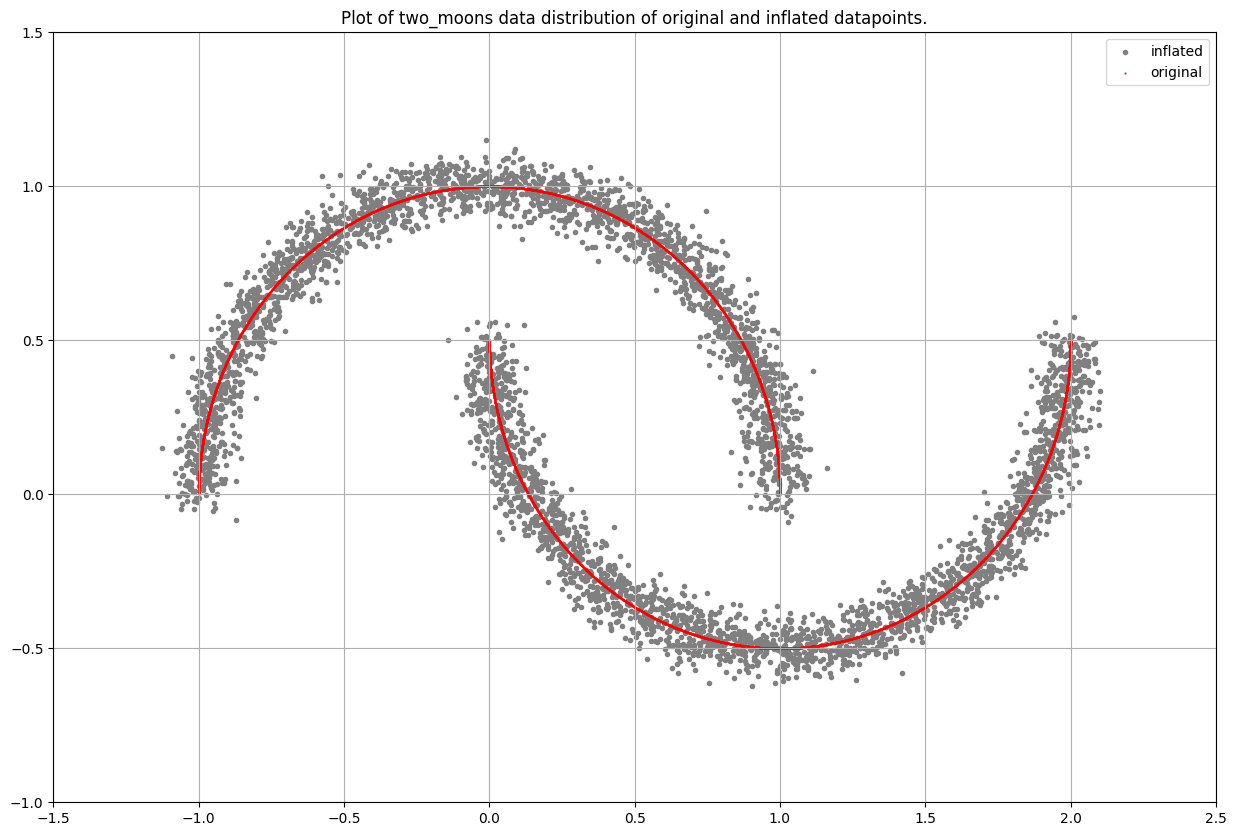

In [ ]:
plot_data(5000, noise_sigma=noise_sigma, data_distribution='two_moons')

## Train the autoencoder

In [ ]:
loss = []
def train_AE(batchsize=100, N_iter=1000, data_distribution='two_moons'):
    for i in tqdm(range(N_iter)):
        # reset optimizer by setting all gradients in the network graph to zero
        optimizer_AE.zero_grad()

        # sample data points from the data_distribution without any noise
        if data_distribution=='two_moons':
            data, _ = make_moons(n_samples=batchsize, noise=0)
        elif data_distribution=='two_circles':
            data = two_circles(batchsize)
        # transform into torch.Tensor
        x = torch.Tensor(data).to(device)

        # add noise to the original data to obtain "inflated" datapoints which now occupy the full space
        x_noise = torch.randn_like(x)*noise_sigma
        x_infl = x + x_noise

        # pass data through Autoencoder and obtain reconstructed datapoints
        x_rec = ... # your code here

        # Mean squared error between original and reconstructed data
        loss_MSE = ... # your code here

        # go backwards through network to calculate gradients of the loss
        loss_MSE.backward()

        loss.append(loss_MSE.item())

        # backpropagate and update the weights
        optimizer_AE.step()

In [ ]:
train_AE(batchsize = 100, N_iter = 2000, data_distribution='two_moons')

100%|██████████| 2000/2000 [00:12<00:00, 163.22it/s]


In [ ]:
# Optional: change learning rate
optimizer_AE.param_groups[0]['lr'] = 1e-4 #1e-3

In [ ]:
# Helper functions for plotting smoothly

def gaussian(x, mu=0, sig=1):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def plot_gauss_filter(x, filter_lim, filter_N, extrapolate=False):
    x_min_mean, x_max_mean = x[0], x[-filter_N:].mean()
    if extrapolate:
        fit = np.polyfit(np.arange(-2*filter_N,0), x[-2*filter_N:], 2, rcond=None, full=False, w=None, cov=False)
        p = np.poly1d(fit)
        x_extrapolate = p(np.arange(0*filter_N, 1*filter_N))
    else:
        x_extrapolate = np.repeat(x_max_mean, filter_N, axis=0)
    x = np.concatenate((np.repeat(x_min_mean, filter_N, axis=0), x, x_extrapolate), axis=None)
    #x = np.concatenate((np.repeat(x_min_mean, filter_N, axis=0), x, np.repeat(x_max_mean, filter_N, axis=0)), axis=None)
    min, max = 3*filter_N//2-1, -3*filter_N//2
    return np.convolve(x, gaussian(np.linspace(-filter_lim,filter_lim,filter_N))/np.sum(gaussian(np.linspace(-filter_lim,filter_lim,filter_N))))[min:max]

def plot_loss(x, label, filter_lim, filter_N, color, alpha=0.4, width=2, extrapolate=False, plot_min_average=False, N_min_average=None, alpha_min=None):
    assert (filter_N <= x.shape[0]//2), "Decrease filter_N!"
    x_smooth = plot_gauss_filter(x, filter_lim, filter_N, extrapolate=extrapolate)
    plt.plot(x, color=color, alpha=alpha)
    plt.plot(x_smooth, label=label, color=color, linewidth=width)
    # Plot a running average of minimum
    if plot_min_average:
        if N_min_average == None:
            N_min_average = filter_N      
        x_min_smooth = []
        for i in range(x.shape[0]):
            i_min, i_max = i-N_min_average, i+N_min_average
            if i_min<0: i_min=0
            if i_max>x.shape[0]: i_max = x.shape[0]
            x_min = np.min(x[i_min:i_max])
            x_min_smooth.append(x_min)
        x_min_smooth = plot_gauss_filter(np.array(x_min_smooth), filter_lim, filter_N, extrapolate=extrapolate)
        if alpha_min == None:
            alpha_min = alpha+0.1
        plt.plot(x_min_smooth, label=label+' min', color=color, linewidth=width, alpha=alpha_min)
    return

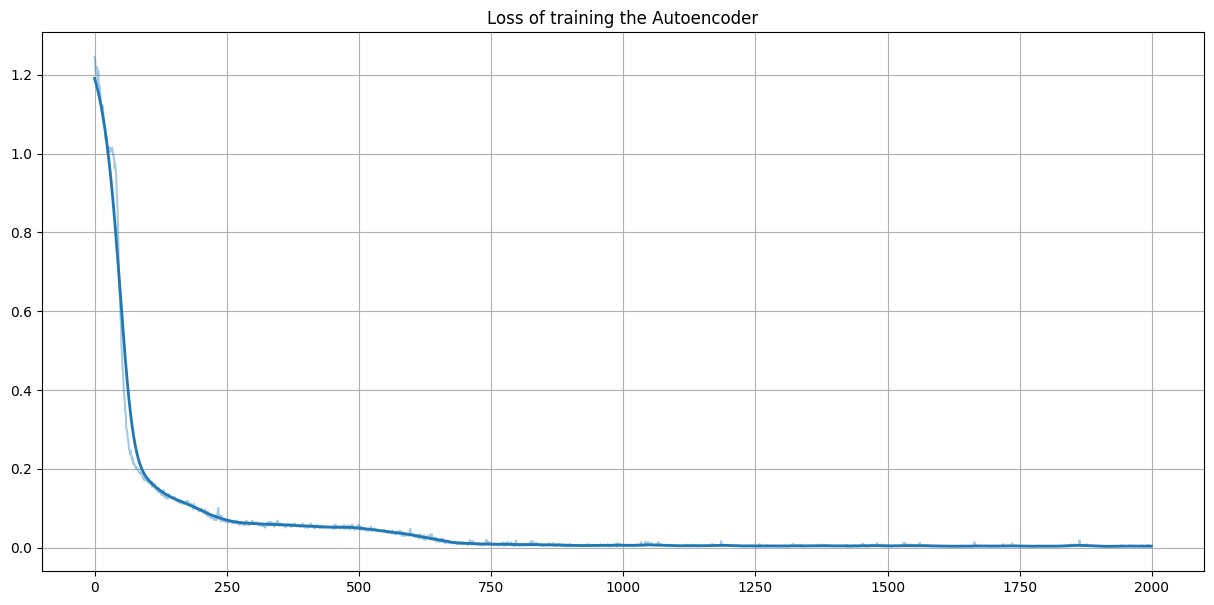

In [ ]:
plt.figure(figsize=(15, 7))
filter_N = 100 # Number of data points over which to smooth out
plot_loss(np.array(loss), 'MSE', 3, filter_N, color='tab:blue', alpha=0.4, plot_min_average=False, N_min_average=10)

plt.title('Loss of training the Autoencoder')
plt.grid()
#plt.ylim(0, 0.2)
#plt.yscale('log')
plt.show()

In [ ]:
def plot_AE_rec(batchsize = 5000, data_distribution='two_moons'):
    if data_distribution=='two_moons':
        data, _ = make_moons(n_samples=batchsize, noise=0)
    elif data_distribution=='two_circles':
        data = two_circles(batchsize)

    x = torch.Tensor(data).to(device)
    x_noise = torch.randn_like(x)*noise_sigma
    x_infl = x + x_noise

    x_rec = ... # your code here

    x = x.cpu().detach().numpy()
    x_infl = x_infl.cpu().detach().numpy()
    x_rec = x_rec.cpu().detach().numpy()
    
    plt.figure(figsize=(15,10))
    plt.title(f'Plot of Autoencoder reconstruction of {data_distribution} data distribution.')
    plt.grid()
    plt.scatter(x_infl[:,0], x_infl[:,1], marker='.', c='gray', label='inflated')
    plt.scatter(x[:,0], x[:,1], c='red', s=3, label='original')
    plt.scatter(x_rec[:,0], x_rec[:,1], s=3, label='reconstructed')
    plt.xlim([-1.5,2.5])
    plt.ylim([-1.0,1.5])
    plt.legend()
    plt.show()

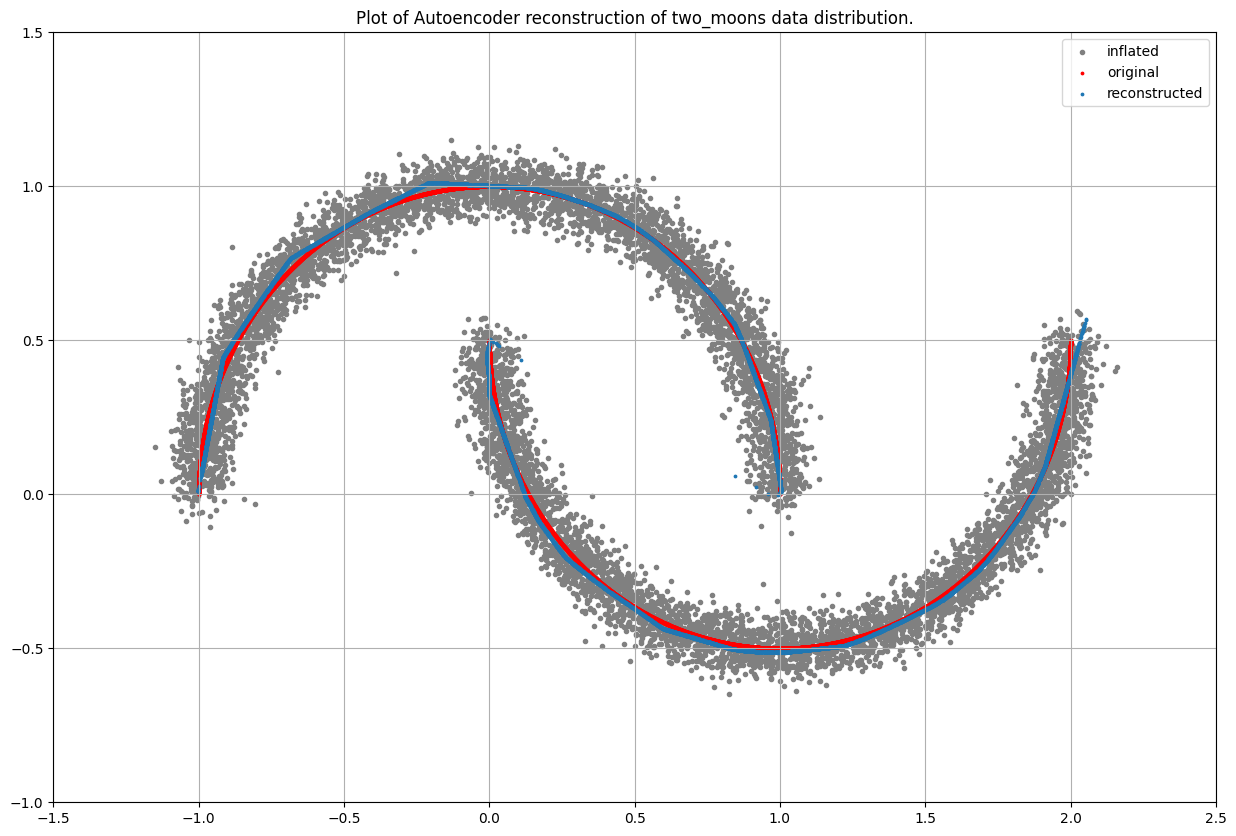

In [ ]:
plot_AE_rec(batchsize = 10000, data_distribution='two_moons')

## Show latent code distribution

In [ ]:
def plot_AE_code(batchsize = 5000, bins=200, data_distribution='two_moons'):
    if data_distribution=='two_moons':
        data, _ = make_moons(n_samples=batchsize, noise=0)
    elif data_distribution=='two_circles':
        data = two_circles(batchsize)

    x = torch.Tensor(data).to(device)
    x_noise = torch.randn_like(x)*noise_sigma

    x_infl = x + x_noise

    z_orig = AE.encode(x)
    z_infl = AE.encode(x_infl)

    x = x.cpu().detach().numpy()
    x_infl = x_infl.cpu().detach().numpy()
    z_orig = z_orig.cpu().detach().numpy()
    z_infl = z_infl.cpu().detach().numpy()

    plt.figure(figsize=(15,10))
    plt.title('Histogramm of latent code of original data without noise')#
    plt.xlabel('latent code z')
    plt.hist(z_orig, bins=bins)
    plt.show()


    plt.figure(figsize=(15,10))
    plt.title('Histogramm of latent code of inflated data with noise')
    plt.xlabel('latent code z')
    plt.hist(z_infl, bins=bins, color='orange')
    plt.show()

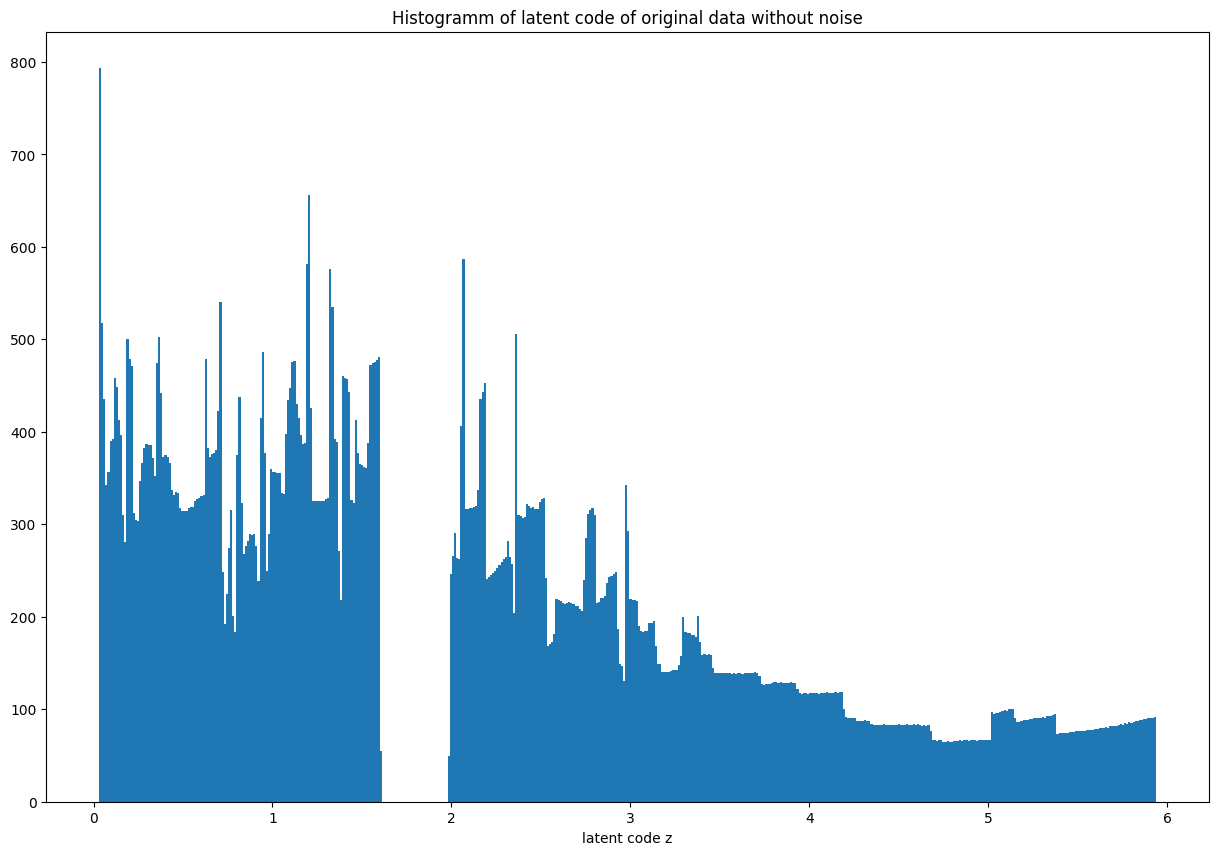

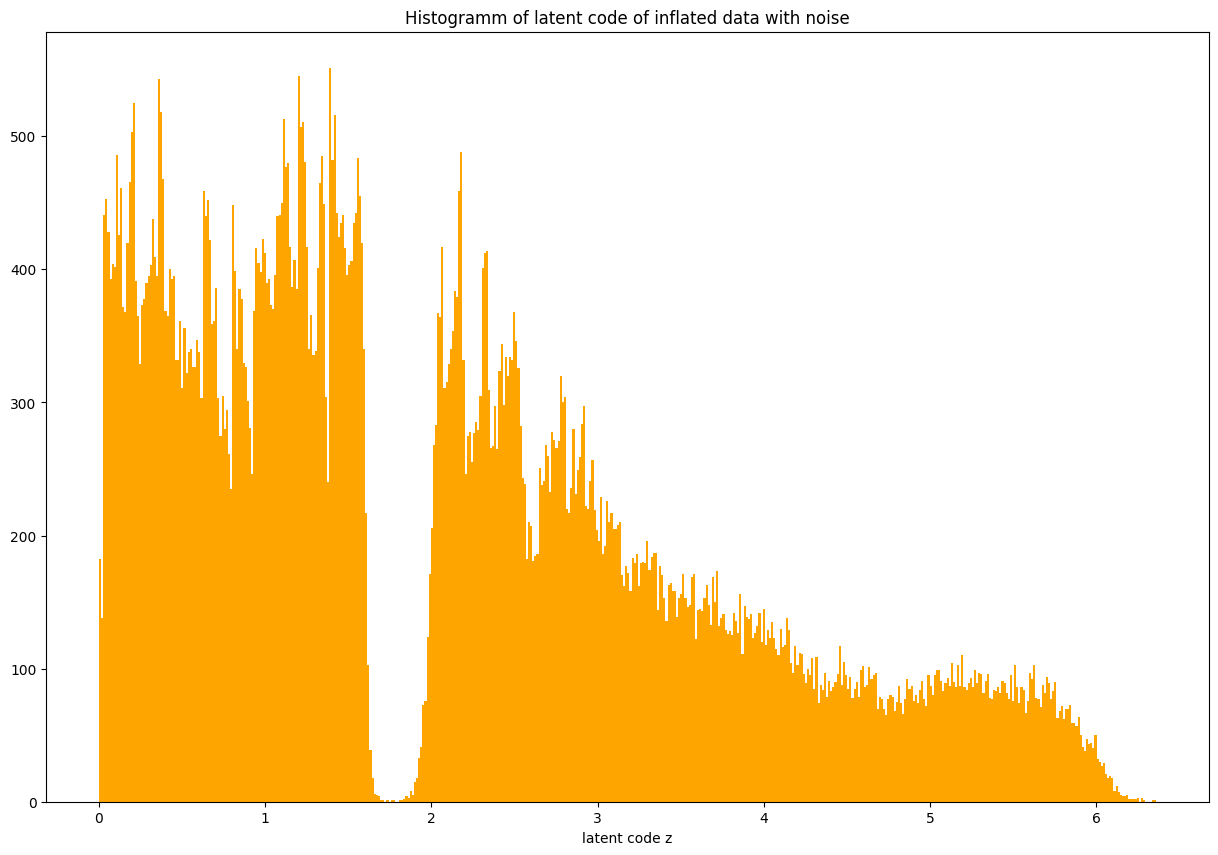

In [ ]:
plot_AE_code(batchsize = 100000, bins=500)

For the two_moons distribution we observe a dip in the histogramm, this is where the autoencoder makes the bridge between the two moons. Also there are only positive z values, this is because we used a ReLU activation function in the last layer of the Encoder.

## Try out different manifold 'two_circles'

In [ ]:
def two_circles(N_points, alpha=-90, theta=270):
    # alpha in degrees controls the angle by which the circle is rotated counterclockwise
    # theta in degrees controls how large the circle is opened, 360 corresponds to a full circle, 180 to a halfmoon, starting at (1, 0) and going counterclockwise
    # Circle centers are located on the y-axis (i.e. x=0). Relative y-positions:
    middle = 0.5
    center_l, center_r  = -0.25, 1.25
    assert middle >= center_l and middle <= center_r
    
    radius_l, radius_r = middle - center_l, center_r - middle
    length_l, length_r = 2*np.pi*radius_l * theta/360, 2*np.pi*radius_r * theta/360
    p_l, p_r = length_l/(length_l+length_r), length_r/(length_l+length_r) #priors

    angle_points = np.random.rand(N_points)*theta #Angle goes from 0 to theta (for left and right quarter circle respectively)

    mask = np.random.choice(a=[True, False], size=(N_points), p=[p_l, p_r])
    angle_points = np.where(mask, angle_points-theta, angle_points) #goes from -theta to theta
    points_l = np.array([radius_l*np.sin(np.radians(angle_points)), radius_l*np.cos(np.radians(angle_points)) + center_l])
    points_r = np.array([radius_r*np.sin(np.radians(angle_points)), center_r - radius_r*np.cos(np.radians(angle_points))])
    points = np.where(angle_points < 0, points_l, points_r)

    c, s = np.cos(np.radians(alpha)), np.sin(np.radians(alpha))
    R = np.array(((c, -s), (s, c)))
    points = R@points

    return points.T

Vary theta up to 360 degress until the distribution becomes an infinity symbol and observe the reconstruction.

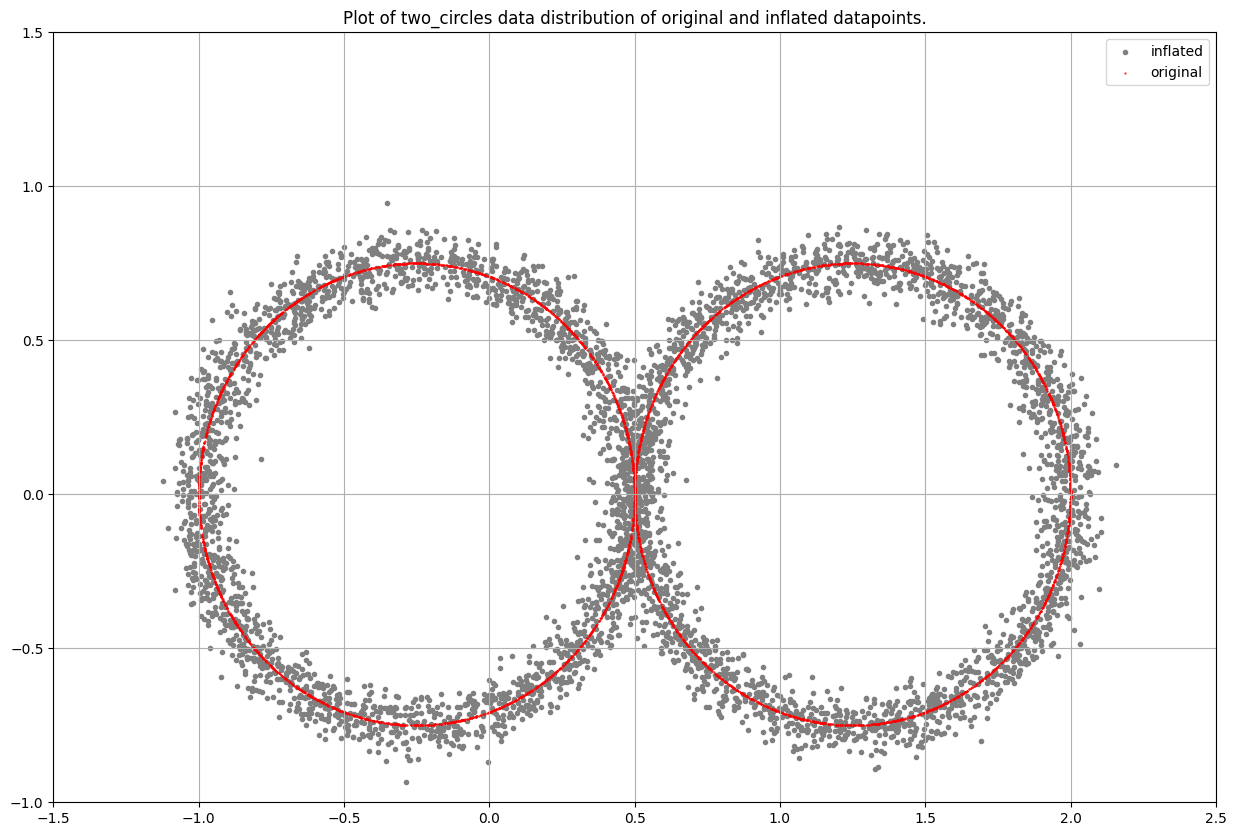

In [ ]:
plot_data(5000, noise_sigma=noise_sigma, data_distribution='two_circles')

In [ ]:
# Initialize autoencoder
AE = Autoencoder(input_dim=2, code_dim=1, hidden_dim=128, n_layer=6, act_fct=nn.ReLU()) #try also act_fct=nn.Tanh() and compare the result
AE = AE.to(device)

# Initialize optimizer
optimizer_AE = torch.optim.AdamW(AE.parameters(), lr=1e-3, weight_decay=1e-5)

The autoencoder with hidden_dim=64 and n_layer=4 is not powerful enough to learn the two_circles distribution. Use 128 hidden dimensions instead.

In [ ]:
loss = []
train_AE(batchsize = 100, N_iter = 2000, data_distribution='two_circles')

100%|██████████| 2000/2000 [00:07<00:00, 283.67it/s]


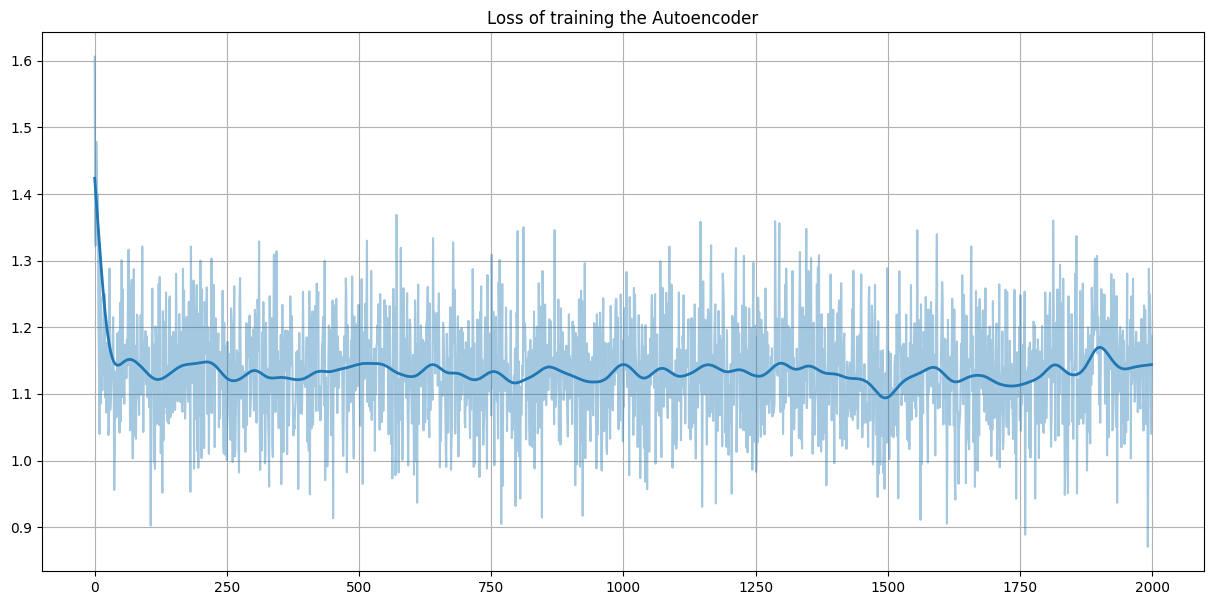

In [ ]:
plt.figure(figsize=(15, 7))
filter_N = 100 # Number of data points over which to smooth out
plot_loss(np.array(loss), 'MSE', 3, filter_N, color='tab:blue', alpha=0.4, plot_min_average=False, N_min_average=10)

plt.title('Loss of training the Autoencoder')
plt.grid()
#plt.ylim(0, 0.2)
#plt.yscale('log')
plt.show()

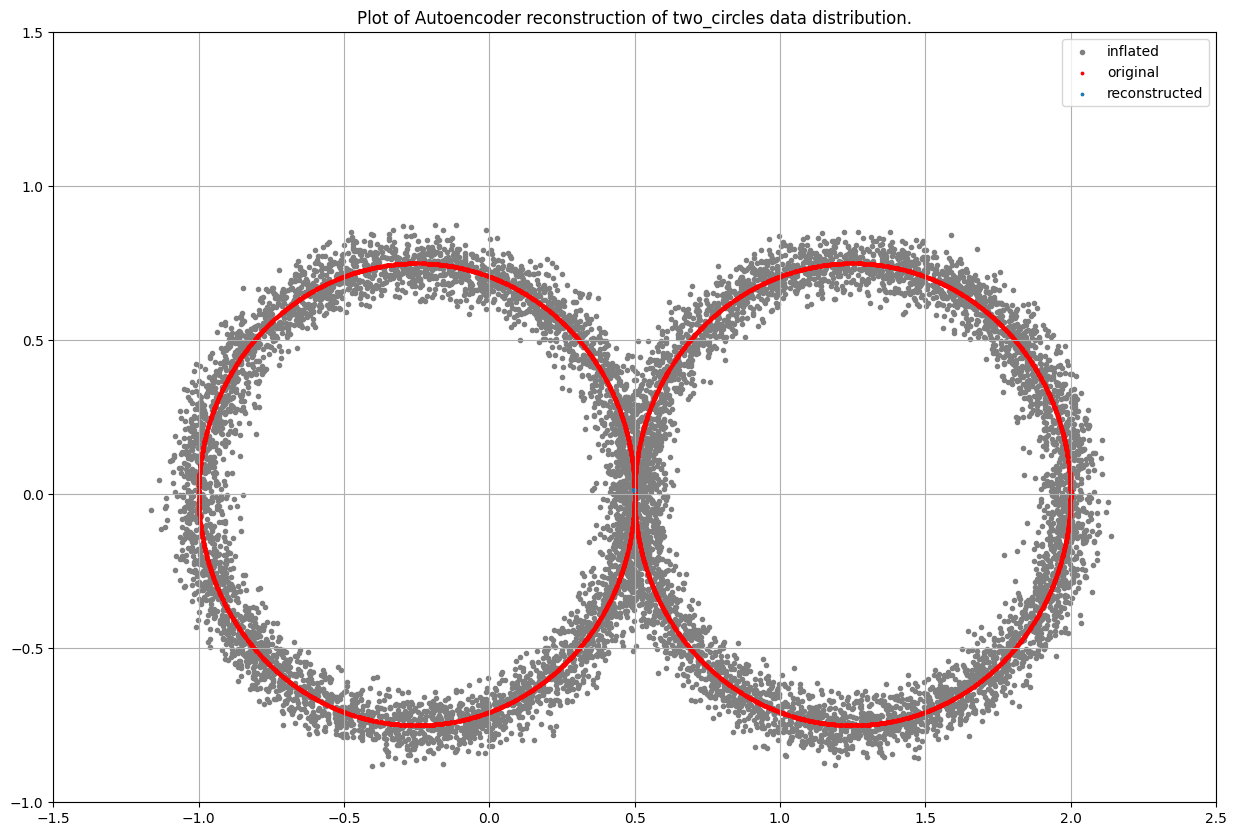

In [ ]:
plot_AE_rec(batchsize = 10000, data_distribution='two_circles')